# **Option Greeks: Theory, Mathematics, and Implementation**

In this comprehensive notebook, we will explore the fundamental risk sensitivities known as "Greeks" in options trading. The Greeks measure how the price of an option changes in response to various market parameters.

We will cover:

- **Delta (Δ)**: Sensitivity to underlying asset price changes
- **Gamma (Γ)**: Rate of change of Delta
- **Theta (Θ)**: Time decay sensitivity
- **Vega (ν)**: Volatility sensitivity
- **Rho (ρ)**: Interest rate sensitivity

For each Greek, we will:
1. Define its economic meaning
2. Derive the mathematical formula
3. Implement both analytical and numerical calculation methods
4. Validate results and explore behavior
5. Visualize how each Greek behaves under different market conditions

---

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.misc import derivative
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Black-Scholes Formula Foundation

Before diving into the Greeks, let's establish the Black-Scholes formula for European options, as all Greeks are derivatives of this fundamental pricing equation.

### European Call Option Price:
$$C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)$$

### European Put Option Price:
$$P = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)$$

Where:
$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$
$$d_2 = d_1 - \sigma\sqrt{T}$$

**Parameters:**
- $S_0$ = Current stock price
- $K$ = Strike price
- $T$ = Time to expiration
- $r$ = Risk-free interest rate
- $\sigma$ = Volatility
- $\Phi(\cdot)$ = Cumulative standard normal distribution function

In [16]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration (in years)
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    float
        Option price
    """
    if T <= 0:
        if option_type.lower() == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

def calculate_d1_d2(S, K, T, r, sigma):
    """
    Calculate d1 and d2 parameters for Black-Scholes formula.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

# Test the implementation
S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2

call_price = black_scholes_price(S0, K, T, r, sigma, 'call')
put_price = black_scholes_price(S0, K, T, r, sigma, 'put')

print(f"Test Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}")
print(f"Call Price: ${call_price:.4f}")
print(f"Put Price:  ${put_price:.4f}")
print(f"Put-Call Parity Check: C - P = {call_price - put_price:.4f}, S - Ke^(-rT) = {S0 - K*np.exp(-r*T):.4f}")

Test Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2
Call Price: $10.4506
Put Price:  $5.5735
Put-Call Parity Check: C - P = 4.8771, S - Ke^(-rT) = 4.8771


## 2. Delta (Δ) - Price Sensitivity

**Definition:** Delta measures the rate of change of the option price with respect to changes in the underlying asset price.

**Economic Interpretation:** 
- For a call option, Delta represents the probability that the option will finish in-the-money
- Delta indicates how many shares of the underlying asset to hold to create a delta-neutral hedge
- Delta ranges from 0 to 1 for calls, and -1 to 0 for puts

### Mathematical Formulation:

**For Call Options:**
$$\Delta_{call} = \frac{\partial C}{\partial S} = \Phi(d_1)$$

**For Put Options:**
$$\Delta_{put} = \frac{\partial P}{\partial S} = \Phi(d_1) - 1 = -\Phi(-d_1)$$

### Derivation:
Starting with the call option formula:
$$C = S\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

Taking the partial derivative with respect to S:
$$\frac{\partial C}{\partial S} = \Phi(d_1) + S\phi(d_1)\frac{\partial d_1}{\partial S} - Ke^{-rT}\phi(d_2)\frac{\partial d_2}{\partial S}$$

Where:
$$\frac{\partial d_1}{\partial S} = \frac{1}{S\sigma\sqrt{T}}$$
$$\frac{\partial d_2}{\partial S} = \frac{1}{S\sigma\sqrt{T}}$$

After substitution and using the relationship $S\phi(d_1) = Ke^{-rT}\phi(d_2)$, the middle terms cancel out, leaving:
$$\Delta_{call} = \Phi(d_1)$$

In [17]:
def delta_analytical(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Delta using analytical Black-Scholes formula.
    """
    if T <= 0:
        return 0.0
    
    d1, d2 = calculate_d1_d2(S, K, T, r, sigma)
    
    if option_type.lower() == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def delta_numerical(S, K, T, r, sigma, option_type='call', h=0.01):
    """
    Calculate Delta using numerical differentiation (finite difference).
    """
    price_up = black_scholes_price(S + h, K, T, r, sigma, option_type)
    price_down = black_scholes_price(S - h, K, T, r, sigma, option_type)
    return (price_up - price_down) / (2 * h)

# Test Delta calculations
print("=== DELTA CALCULATIONS ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

# Call Delta
call_delta_analytical = delta_analytical(S0, K, T, r, sigma, 'call')
call_delta_numerical = delta_numerical(S0, K, T, r, sigma, 'call')

print(f"Call Delta (Analytical): {call_delta_analytical:.6f}")
print(f"Call Delta (Numerical):  {call_delta_numerical:.6f}")
print(f"Difference:              {abs(call_delta_analytical - call_delta_numerical):.8f}\n")

# Put Delta
put_delta_analytical = delta_analytical(S0, K, T, r, sigma, 'put')
put_delta_numerical = delta_numerical(S0, K, T, r, sigma, 'put')

print(f"Put Delta (Analytical):  {put_delta_analytical:.6f}")
print(f"Put Delta (Numerical):   {put_delta_numerical:.6f}")
print(f"Difference:              {abs(put_delta_analytical - put_delta_numerical):.8f}\n")

# Verification: Call Delta - Put Delta should equal 1
delta_difference = call_delta_analytical - put_delta_analytical
print(f"Call Delta - Put Delta = {delta_difference:.6f} (should be 1.0)")

=== DELTA CALCULATIONS ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2

Call Delta (Analytical): 0.636831
Call Delta (Numerical):  0.636831
Difference:              0.00000001

Put Delta (Analytical):  -0.363169
Put Delta (Numerical):   -0.363169
Difference:              0.00000001

Call Delta - Put Delta = 1.000000 (should be 1.0)


## 3. Gamma (Γ) - Delta Sensitivity

**Definition:** Gamma measures the rate of change of Delta with respect to changes in the underlying asset price.

**Economic Interpretation:**
- Gamma indicates how much the hedge ratio (Delta) will change as the stock price moves
- Higher Gamma means Delta changes more rapidly, requiring more frequent rebalancing
- Gamma is always positive for both calls and puts
- Gamma is highest for at-the-money options and approaches zero for deep in/out-of-the-money options

### Mathematical Formulation:

**For Both Call and Put Options:**
$$\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{\partial^2 P}{\partial S^2} = \frac{\phi(d_1)}{S\sigma\sqrt{T}}$$

Where $\phi(d_1) = \frac{1}{\sqrt{2\pi}}e^{-d_1^2/2}$ is the standard normal probability density function.

### Derivation:
Starting with Delta for a call:
$$\Delta = \Phi(d_1)$$

Taking the partial derivative with respect to S:
$$\Gamma = \frac{\partial \Delta}{\partial S} = \frac{\partial \Phi(d_1)}{\partial S} = \phi(d_1) \frac{\partial d_1}{\partial S}$$

Since $\frac{\partial d_1}{\partial S} = \frac{1}{S\sigma\sqrt{T}}$:
$$\Gamma = \frac{\phi(d_1)}{S\sigma\sqrt{T}}$$

In [18]:
def gamma_analytical(S, K, T, r, sigma):
    """
    Calculate Gamma using analytical Black-Scholes formula.
    Gamma is the same for both calls and puts.
    """
    if T <= 0:
        return 0.0
    
    d1, d2 = calculate_d1_d2(S, K, T, r, sigma)
    
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def gamma_numerical(S, K, T, r, sigma, option_type='call', h=0.01):
    """
    Calculate Gamma using numerical differentiation (second derivative).
    """
    delta_up = delta_analytical(S + h, K, T, r, sigma, option_type)
    delta_down = delta_analytical(S - h, K, T, r, sigma, option_type)
    return (delta_up - delta_down) / (2 * h)

def gamma_numerical_alternative(S, K, T, r, sigma, option_type='call', h=0.01):
    """
    Alternative numerical calculation using second finite difference of price.
    """
    price_up = black_scholes_price(S + h, K, T, r, sigma, option_type)
    price_center = black_scholes_price(S, K, T, r, sigma, option_type)
    price_down = black_scholes_price(S - h, K, T, r, sigma, option_type)
    
    return (price_up - 2 * price_center + price_down) / (h**2)

# Test Gamma calculations
print("=== GAMMA CALCULATIONS ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

gamma_analytical_value = gamma_analytical(S0, K, T, r, sigma)
gamma_numerical_delta = gamma_numerical(S0, K, T, r, sigma, 'call')
gamma_numerical_price = gamma_numerical_alternative(S0, K, T, r, sigma, 'call')

print(f"Gamma (Analytical):           {gamma_analytical_value:.8f}")
print(f"Gamma (Numerical via Delta):  {gamma_numerical_delta:.8f}")
print(f"Gamma (Numerical via Price):  {gamma_numerical_price:.8f}")
print(f"Difference (Analytical vs Numerical): {abs(gamma_analytical_value - gamma_numerical_delta):.10f}\n")

# Test that Gamma is the same for calls and puts
gamma_call = gamma_numerical(S0, K, T, r, sigma, 'call')
gamma_put = gamma_numerical(S0, K, T, r, sigma, 'put')
print(f"Gamma Call:  {gamma_call:.8f}")
print(f"Gamma Put:   {gamma_put:.8f}")
print(f"Difference:  {abs(gamma_call - gamma_put):.10f} (should be ~0)")

=== GAMMA CALCULATIONS ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2

Gamma (Analytical):           0.01876202
Gamma (Numerical via Delta):  0.01876202
Gamma (Numerical via Price):  0.01876202
Difference (Analytical vs Numerical): 0.0000000005

Gamma Call:  0.01876202
Gamma Put:   0.01876202
Difference:  0.0000000000 (should be ~0)


## 4. Theta (Θ) - Time Decay

**Definition:** Theta measures the rate of change of the option price with respect to the passage of time.

**Economic Interpretation:**
- Theta represents time decay - how much value an option loses as time passes
- Theta is typically negative for long positions (options lose value over time)
- Theta accelerates as expiration approaches, especially for at-the-money options
- Often quoted as the dollar amount lost per day

### Mathematical Formulation:

**For Call Options:**
$$\Theta_{call} = \frac{\partial C}{\partial T} = -\frac{S\phi(d_1)\sigma}{2\sqrt{T}} - rKe^{-rT}\Phi(d_2)$$

**For Put Options:**
$$\Theta_{put} = \frac{\partial P}{\partial T} = -\frac{S\phi(d_1)\sigma}{2\sqrt{T}} + rKe^{-rT}\Phi(-d_2)$$

### Derivation:
The derivation involves taking the partial derivative of the Black-Scholes formula with respect to time T. This is more complex than Delta and Gamma as it involves:
1. The term $-\frac{S\phi(d_1)\sigma}{2\sqrt{T}}$ from the time dependency in $d_1$ and $d_2$
2. The term $\pm rKe^{-rT}\Phi(\pm d_2)$ from the discount factor $e^{-rT}$

**Note:** By convention, Theta is often expressed as the change per calendar day, so we divide by 365.

In [19]:
def theta_analytical(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Theta using analytical Black-Scholes formula.
    Returns Theta per year. Divide by 365 for daily Theta.
    """
    if T <= 0:
        return 0.0
    
    d1, d2 = calculate_d1_d2(S, K, T, r, sigma)
    
    # Common term for both calls and puts
    common_term = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    
    if option_type.lower() == 'call':
        theta = common_term - r * K * np.exp(-r * T) * norm.cdf(d2)
    else:
        theta = common_term + r * K * np.exp(-r * T) * norm.cdf(-d2)
    
    return theta

def theta_numerical(S, K, T, r, sigma, option_type='call', h=1/365):
    """
    Calculate Theta using numerical differentiation.
    Default h is 1 day (1/365 years).
    """
    if T <= h:
        return 0.0
    
    price_today = black_scholes_price(S, K, T, r, sigma, option_type)
    price_tomorrow = black_scholes_price(S, K, T - h, r, sigma, option_type)
    
    return (price_tomorrow - price_today) / h

# Test Theta calculations
print("=== THETA CALCULATIONS ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

# Call Theta
call_theta_analytical = theta_analytical(S0, K, T, r, sigma, 'call')
call_theta_numerical = theta_numerical(S0, K, T, r, sigma, 'call')
call_theta_daily = call_theta_analytical / 365  # Convert to daily

print(f"Call Theta (Analytical, Annual): {call_theta_analytical:.6f}")
print(f"Call Theta (Numerical, Annual):  {call_theta_numerical:.6f}")
print(f"Call Theta (Daily):              {call_theta_daily:.6f}")
print(f"Difference:                      {abs(call_theta_analytical - call_theta_numerical):.8f}\n")

# Put Theta
put_theta_analytical = theta_analytical(S0, K, T, r, sigma, 'put')
put_theta_numerical = theta_numerical(S0, K, T, r, sigma, 'put')
put_theta_daily = put_theta_analytical / 365  # Convert to daily

print(f"Put Theta (Analytical, Annual):  {put_theta_analytical:.6f}")
print(f"Put Theta (Numerical, Annual):   {put_theta_numerical:.6f}")
print(f"Put Theta (Daily):               {put_theta_daily:.6f}")
print(f"Difference:                      {abs(put_theta_analytical - put_theta_numerical):.8f}\n")

# Note about Theta signs
print("Note: Negative Theta indicates time decay (option loses value over time)")
print("      This is typical for long option positions.")

=== THETA CALCULATIONS ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2

Call Theta (Analytical, Annual): -6.414028
Call Theta (Numerical, Annual):  -6.416906
Call Theta (Daily):              -0.017573
Difference:                      0.00287826

Put Theta (Analytical, Annual):  -1.657880
Put Theta (Numerical, Annual):   -1.660433
Put Theta (Daily):               -0.004542
Difference:                      0.00255248

Note: Negative Theta indicates time decay (option loses value over time)
      This is typical for long option positions.


## 5. Vega (ν) - Volatility Sensitivity

**Definition:** Vega measures the rate of change of the option price with respect to changes in the volatility of the underlying asset.

**Economic Interpretation:**
- Vega indicates how much the option price will change for a 1% change in implied volatility
- Vega is always positive for both calls and puts (higher volatility increases option value)
- Vega is highest for at-the-money options and decreases as options move in/out-of-the-money
- Vega decreases as expiration approaches (volatility matters less with little time left)

### Mathematical Formulation:

**For Both Call and Put Options:**
$$\nu = \frac{\partial C}{\partial \sigma} = \frac{\partial P}{\partial \sigma} = S\sqrt{T}\phi(d_1)$$

### Derivation:
Starting with the call option formula and taking the partial derivative with respect to σ:

$$\frac{\partial C}{\partial \sigma} = S\phi(d_1)\frac{\partial d_1}{\partial \sigma} - Ke^{-rT}\phi(d_2)\frac{\partial d_2}{\partial \sigma}$$

Where:
$$\frac{\partial d_1}{\partial \sigma} = \frac{-\ln(S/K) - (r + \sigma^2/2)T}{\sigma^2\sqrt{T}} + \frac{\sqrt{T}}{1} = \frac{\sqrt{T}\sigma - d_1}{\sigma}$$
$$\frac{\partial d_2}{\partial \sigma} = \frac{\partial d_1}{\partial \sigma} - \sqrt{T} = \frac{-d_1}{\sigma}$$

After substitution and using the relationship $S\phi(d_1) = Ke^{-rT}\phi(d_2)$:
$$\nu = S\sqrt{T}\phi(d_1)$$

**Note:** Vega is often quoted per 1% change in volatility, so the result may be divided by 100.

In [20]:
def vega_analytical(S, K, T, r, sigma):
    """
    Calculate Vega using analytical Black-Scholes formula.
    Vega is the same for both calls and puts.
    Returns Vega for a 100% change in volatility.
    """
    if T <= 0:
        return 0.0
    
    d1, d2 = calculate_d1_d2(S, K, T, r, sigma)
    
    return S * np.sqrt(T) * norm.pdf(d1)

def vega_numerical(S, K, T, r, sigma, option_type='call', h=0.01):
    """
    Calculate Vega using numerical differentiation.
    Default h=0.01 represents a 1% change in volatility.
    """
    price_up = black_scholes_price(S, K, T, r, sigma + h, option_type)
    price_down = black_scholes_price(S, K, T, r, sigma - h, option_type)
    
    return (price_up - price_down) / (2 * h)

# Test Vega calculations
print("=== VEGA CALCULATIONS ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

vega_analytical_value = vega_analytical(S0, K, T, r, sigma)
vega_numerical_call = vega_numerical(S0, K, T, r, sigma, 'call')
vega_numerical_put = vega_numerical(S0, K, T, r, sigma, 'put')

# Convert to per 1% change in volatility
vega_per_percent = vega_analytical_value * 0.01

print(f"Vega (Analytical):                {vega_analytical_value:.6f}")
print(f"Vega (Numerical, Call):           {vega_numerical_call:.6f}")
print(f"Vega (Numerical, Put):            {vega_numerical_put:.6f}")
print(f"Vega per 1% volatility change:    {vega_per_percent:.6f}")
print(f"Difference (Analytical vs Numerical): {abs(vega_analytical_value - vega_numerical_call):.8f}\n")

# Test that Vega is the same for calls and puts
print(f"Verification: Vega should be the same for calls and puts")
print(f"Difference between call and put Vega: {abs(vega_numerical_call - vega_numerical_put):.10f}")

# Practical interpretation
print(f"\nPractical Interpretation:")
print(f"If volatility increases by 1% (from {sigma*100:.0f}% to {(sigma+0.01)*100:.0f}%), ")
print(f"the option price will increase by approximately ${vega_per_percent:.4f}")

=== VEGA CALCULATIONS ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2

Vega (Analytical):                37.524035
Vega (Numerical, Call):           37.520983
Vega (Numerical, Put):            37.520983
Vega per 1% volatility change:    0.375240
Difference (Analytical vs Numerical): 0.00305164

Verification: Vega should be the same for calls and puts
Difference between call and put Vega: 0.0000000000

Practical Interpretation:
If volatility increases by 1% (from 20% to 21%), 
the option price will increase by approximately $0.3752


## 6. Rho (ρ) - Interest Rate Sensitivity

**Definition:** Rho measures the rate of change of the option price with respect to changes in the risk-free interest rate.

**Economic Interpretation:**
- Rho indicates how much the option price will change for a 1% change in interest rates
- Call options have positive Rho (higher rates increase call value)
- Put options have negative Rho (higher rates decrease put value)
- Rho is generally small compared to other Greeks, except for long-term options

### Mathematical Formulation:

**For Call Options:**
$$\rho_{call} = \frac{\partial C}{\partial r} = KTe^{-rT}\Phi(d_2)$$

**For Put Options:**
$$\rho_{put} = \frac{\partial P}{\partial r} = -KTe^{-rT}\Phi(-d_2)$$

### Derivation:
Starting with the call option formula:
$$C = S\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

Taking the partial derivative with respect to r:
$$\frac{\partial C}{\partial r} = S\phi(d_1)\frac{\partial d_1}{\partial r} - K\left[\frac{\partial e^{-rT}}{\partial r}\Phi(d_2) + e^{-rT}\phi(d_2)\frac{\partial d_2}{\partial r}\right]$$

Where:
$$\frac{\partial d_1}{\partial r} = \frac{\sqrt{T}}{\sigma}$$
$$\frac{\partial d_2}{\partial r} = \frac{\sqrt{T}}{\sigma}$$
$$\frac{\partial e^{-rT}}{\partial r} = -Te^{-rT}$$

After substitution and using the relationship $S\phi(d_1) = Ke^{-rT}\phi(d_2)$, the derivative terms cancel out:
$$\rho_{call} = KTe^{-rT}\Phi(d_2)$$

**Note:** Rho is often quoted per 1% change in interest rates, so the result may be divided by 100.

In [21]:
def rho_analytical(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Rho using analytical Black-Scholes formula.
    Returns Rho for a 100% change in interest rate.
    """
    if T <= 0:
        return 0.0
    
    d1, d2 = calculate_d1_d2(S, K, T, r, sigma)
    
    if option_type.lower() == 'call':
        return K * T * np.exp(-r * T) * norm.cdf(d2)
    else:
        return -K * T * np.exp(-r * T) * norm.cdf(-d2)

def rho_numerical(S, K, T, r, sigma, option_type='call', h=0.01):
    """
    Calculate Rho using numerical differentiation.
    Default h=0.01 represents a 1% change in interest rate.
    """
    price_up = black_scholes_price(S, K, T, r + h, sigma, option_type)
    price_down = black_scholes_price(S, K, T, r - h, sigma, option_type)
    
    return (price_up - price_down) / (2 * h)

# Test Rho calculations
print("=== RHO CALCULATIONS ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

# Call Rho
call_rho_analytical = rho_analytical(S0, K, T, r, sigma, 'call')
call_rho_numerical = rho_numerical(S0, K, T, r, sigma, 'call')
call_rho_per_percent = call_rho_analytical * 0.01

print(f"Call Rho (Analytical):            {call_rho_analytical:.6f}")
print(f"Call Rho (Numerical):             {call_rho_numerical:.6f}")
print(f"Call Rho per 1% rate change:      {call_rho_per_percent:.6f}")
print(f"Difference:                       {abs(call_rho_analytical - call_rho_numerical):.8f}\n")

# Put Rho
put_rho_analytical = rho_analytical(S0, K, T, r, sigma, 'put')
put_rho_numerical = rho_numerical(S0, K, T, r, sigma, 'put')
put_rho_per_percent = put_rho_analytical * 0.01

print(f"Put Rho (Analytical):             {put_rho_analytical:.6f}")
print(f"Put Rho (Numerical):              {put_rho_numerical:.6f}")
print(f"Put Rho per 1% rate change:       {put_rho_per_percent:.6f}")
print(f"Difference:                       {abs(put_rho_analytical - put_rho_numerical):.8f}\n")

# Practical interpretation
print(f"Practical Interpretation:")
print(f"If interest rates increase by 1% (from {r*100:.0f}% to {(r+0.01)*100:.0f}%):")
print(f"- Call option price will change by ${call_rho_per_percent:.4f}")
print(f"- Put option price will change by ${put_rho_per_percent:.4f}")
print(f"\nNote: Call Rho > 0 (rates up → call value up)")
print(f"      Put Rho < 0 (rates up → put value down)")

=== RHO CALCULATIONS ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2

Call Rho (Analytical):            53.232482
Call Rho (Numerical):             53.224772
Call Rho per 1% rate change:      0.532325
Difference:                       0.00770978

Put Rho (Analytical):             -41.890461
Put Rho (Numerical):              -41.899756
Put Rho per 1% rate change:       -0.418905
Difference:                       0.00929517

Practical Interpretation:
If interest rates increase by 1% (from 5% to 6%):
- Call option price will change by $0.5323
- Put option price will change by $-0.4189

Note: Call Rho > 0 (rates up → call value up)
      Put Rho < 0 (rates up → put value down)


## 7. Comprehensive Greeks Calculator

Let's create a comprehensive class that calculates all Greeks using both analytical and numerical methods, and provides easy comparison and validation.

In [22]:
class GreeksCalculator:
    """
    Comprehensive calculator for option Greeks using Black-Scholes model.
    Provides both analytical and numerical calculation methods.
    """
    
    def __init__(self, S, K, T, r, sigma):
        """
        Initialize the calculator with option parameters.
        
        Parameters:
        -----------
        S : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate
        sigma : float
            Volatility
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        
        # Calculate d1 and d2
        if T > 0:
            self.d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            self.d2 = self.d1 - sigma * np.sqrt(T)
        else:
            self.d1 = self.d2 = 0
    
    def price(self, option_type='call'):
        """Calculate option price using Black-Scholes formula."""
        return black_scholes_price(self.S, self.K, self.T, self.r, self.sigma, option_type)
    
    def delta(self, option_type='call', method='analytical'):
        """Calculate Delta."""
        if method == 'analytical':
            return delta_analytical(self.S, self.K, self.T, self.r, self.sigma, option_type)
        else:
            return delta_numerical(self.S, self.K, self.T, self.r, self.sigma, option_type)
    
    def gamma(self, method='analytical'):
        """Calculate Gamma (same for calls and puts)."""
        if method == 'analytical':
            return gamma_analytical(self.S, self.K, self.T, self.r, self.sigma)
        else:
            return gamma_numerical(self.S, self.K, self.T, self.r, self.sigma)
    
    def theta(self, option_type='call', method='analytical', per_day=True):
        """Calculate Theta."""
        if method == 'analytical':
            theta_val = theta_analytical(self.S, self.K, self.T, self.r, self.sigma, option_type)
        else:
            theta_val = theta_numerical(self.S, self.K, self.T, self.r, self.sigma, option_type)
        
        return theta_val / 365 if per_day else theta_val
    
    def vega(self, method='analytical', per_percent=True):
        """Calculate Vega (same for calls and puts)."""
        if method == 'analytical':
            vega_val = vega_analytical(self.S, self.K, self.T, self.r, self.sigma)
        else:
            vega_val = vega_numerical(self.S, self.K, self.T, self.r, self.sigma)
        
        return vega_val * 0.01 if per_percent else vega_val
    
    def rho(self, option_type='call', method='analytical', per_percent=True):
        """Calculate Rho."""
        if method == 'analytical':
            rho_val = rho_analytical(self.S, self.K, self.T, self.r, self.sigma, option_type)
        else:
            rho_val = rho_numerical(self.S, self.K, self.T, self.r, self.sigma, option_type)
        
        return rho_val * 0.01 if per_percent else rho_val
    
    def all_greeks(self, option_type='call', method='analytical'):
        """
        Calculate all Greeks at once.
        
        Returns:
        --------
        dict
            Dictionary containing all Greeks
        """
        return {
            'price': self.price(option_type),
            'delta': self.delta(option_type, method),
            'gamma': self.gamma(method),
            'theta': self.theta(option_type, method, per_day=True),
            'vega': self.vega(method, per_percent=True),
            'rho': self.rho(option_type, method, per_percent=True)
        }
    
    def compare_methods(self, option_type='call'):
        """
        Compare analytical vs numerical methods for all Greeks.
        
        Returns:
        --------
        pandas.DataFrame
            Comparison table
        """
        analytical = self.all_greeks(option_type, 'analytical')
        numerical = self.all_greeks(option_type, 'numerical')
        
        comparison_data = []
        for greek in analytical.keys():
            anal_val = analytical[greek]
            num_val = numerical[greek]
            diff = abs(anal_val - num_val)
            rel_diff = (diff / abs(anal_val)) * 100 if anal_val != 0 else 0
            
            comparison_data.append({
                'Greek': greek.title(),
                'Analytical': f"{anal_val:.8f}",
                'Numerical': f"{num_val:.8f}",
                'Absolute Diff': f"{diff:.2e}",
                'Relative Diff (%)': f"{rel_diff:.4f}"
            })
        
        return pd.DataFrame(comparison_data)
    
    def summary_table(self, option_type='call'):
        """
        Create a summary table of all Greeks with interpretations.
        """
        greeks = self.all_greeks(option_type, 'analytical')
        
        interpretations = {
            'price': f"Current option value: ${greeks['price']:.4f}",
            'delta': f"Price change per $1 stock move: ${greeks['delta']:.4f}",
            'gamma': f"Delta change per $1 stock move: {greeks['gamma']:.6f}",
            'theta': f"Daily time decay: ${greeks['theta']:.4f}",
            'vega': f"Price change per 1% volatility: ${greeks['vega']:.4f}",
            'rho': f"Price change per 1% rate change: ${greeks['rho']:.4f}"
        }
        
        summary_data = []
        for greek, value in greeks.items():
            summary_data.append({
                'Greek': greek.title(),
                'Value': f"{value:.6f}",
                'Interpretation': interpretations[greek]
            })
        
        return pd.DataFrame(summary_data)

# Test the comprehensive calculator
print("=== COMPREHENSIVE GREEKS CALCULATOR TEST ===")
print(f"Parameters: S={S0}, K={K}, T={T}, r={r}, σ={sigma}\n")

calc = GreeksCalculator(S0, K, T, r, sigma)

# Test both call and put
for option_type in ['call', 'put']:
    print(f"\n{option_type.upper()} OPTION GREEKS:")
    print("=" * 50)
    
    # Get all Greeks
    greeks = calc.all_greeks(option_type)
    
    print(f"Price: ${greeks['price']:.6f}")
    print(f"Delta: {greeks['delta']:.6f}")
    print(f"Gamma: {greeks['gamma']:.8f}")
    print(f"Theta: {greeks['theta']:.6f} (per day)")
    print(f"Vega:  {greeks['vega']:.6f} (per 1% vol)")
    print(f"Rho:   {greeks['rho']:.6f} (per 1% rate)")

# Show comparison table for call option
print("\n\nCOMPARISON: ANALYTICAL vs NUMERICAL (Call Option)")
print("=" * 60)
comparison_df = calc.compare_methods('call')
print(comparison_df.to_string(index=False))

=== COMPREHENSIVE GREEKS CALCULATOR TEST ===
Parameters: S=100, K=100, T=1.0, r=0.05, σ=0.2


CALL OPTION GREEKS:
Price: $10.450584
Delta: 0.636831
Gamma: 0.01876202
Theta: -0.017573 (per day)
Vega:  0.375240 (per 1% vol)
Rho:   0.532325 (per 1% rate)

PUT OPTION GREEKS:
Price: $5.573526
Delta: -0.363169
Gamma: 0.01876202
Theta: -0.004542 (per day)
Vega:  0.375240 (per 1% vol)
Rho:   -0.418905 (per 1% rate)


COMPARISON: ANALYTICAL vs NUMERICAL (Call Option)
Greek  Analytical   Numerical Absolute Diff Relative Diff (%)
Price 10.45058357 10.45058357      0.00e+00            0.0000
Delta  0.63683065  0.63683064      8.60e-09            0.0000
Gamma  0.01876202  0.01876202      4.59e-10            0.0000
Theta -0.01757268 -0.01758056      7.89e-06            0.0449
 Vega  0.37524035  0.37520983      3.05e-05            0.0081
  Rho  0.53232482  0.53224772      7.71e-05            0.0145


## 8. Validation and Testing

Let's validate our Greeks calculations using known relationships and edge cases.

In [23]:
def validate_greeks():
    """
    Perform validation tests on Greeks calculations.
    """
    print("=== GREEKS VALIDATION TESTS ===")
    print()
    
    # Test parameters
    S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
    calc = GreeksCalculator(S, K, T, r, sigma)
    
    print("Test 1: Put-Call Parity for Delta")
    print("-" * 40)
    call_delta = calc.delta('call')
    put_delta = calc.delta('put')
    delta_diff = call_delta - put_delta
    print(f"Call Delta - Put Delta = {delta_diff:.6f}")
    print(f"Expected: 1.0000")
    print(f"Test {'PASSED' if abs(delta_diff - 1.0) < 1e-10 else 'FAILED'}")
    print()
    
    print("Test 2: Gamma is the same for calls and puts")
    print("-" * 45)
    gamma_val = calc.gamma()
    # Gamma should be the same for both
    print(f"Gamma (analytical): {gamma_val:.8f}")
    print(f"Test PASSED (by definition - same formula)")
    print()
    
    print("Test 3: Vega is the same for calls and puts")
    print("-" * 43)
    vega_val = calc.vega(per_percent=False)
    print(f"Vega (analytical): {vega_val:.6f}")
    print(f"Test PASSED (by definition - same formula)")
    print()
    
    print("Test 4: At-the-money options have highest Gamma")
    print("-" * 48)
    # Test different moneyness levels
    strikes = [90, 95, 100, 105, 110]
    gammas = []
    for strike in strikes:
        calc_temp = GreeksCalculator(S, strike, T, r, sigma)
        gamma = calc_temp.gamma()
        gammas.append(gamma)
        print(f"Strike {strike}: Gamma = {gamma:.8f}")
    
    max_gamma_idx = np.argmax(gammas)
    print(f"Maximum Gamma at Strike: {strikes[max_gamma_idx]}")
    print(f"Test {'PASSED' if strikes[max_gamma_idx] == 100 else 'FAILED'}")
    print()
    
    print("Test 5: Theta is negative for long positions")
    print("-" * 42)
    call_theta = calc.theta('call', per_day=True)
    put_theta = calc.theta('put', per_day=True)
    print(f"Call Theta: {call_theta:.6f}")
    print(f"Put Theta:  {put_theta:.6f}")
    print(f"Test {'PASSED' if call_theta < 0 and put_theta < 0 else 'FAILED'}")
    print()
    
    print("Test 6: Vega is positive for both calls and puts")
    print("-" * 46)
    vega_val = calc.vega(per_percent=True)
    print(f"Vega: {vega_val:.6f}")
    print(f"Test {'PASSED' if vega_val > 0 else 'FAILED'}")
    print()
    
    print("Test 7: Call Rho > 0, Put Rho < 0")
    print("-" * 34)
    call_rho = calc.rho('call', per_percent=True)
    put_rho = calc.rho('put', per_percent=True)
    print(f"Call Rho: {call_rho:.6f}")
    print(f"Put Rho:  {put_rho:.6f}")
    print(f"Test {'PASSED' if call_rho > 0 and put_rho < 0 else 'FAILED'}")
    print()
    
    print("Test 8: Edge case - At expiration (T=0)")
    print("-" * 38)
    calc_expired = GreeksCalculator(S, K, 0.0, r, sigma)
    
    # At expiration, only intrinsic value matters
    call_price_expired = calc_expired.price('call')
    put_price_expired = calc_expired.price('put')
    expected_call = max(S - K, 0)
    expected_put = max(K - S, 0)
    
    print(f"Call price at expiration: {call_price_expired:.6f} (expected: {expected_call:.6f})")
    print(f"Put price at expiration:  {put_price_expired:.6f} (expected: {expected_put:.6f})")
    
    # Greeks should be zero at expiration
    greeks_expired = calc_expired.all_greeks('call')
    print(f"Greeks at expiration: {greeks_expired}")
    print(f"Test {'PASSED' if all(abs(v) < 1e-10 for k, v in greeks_expired.items() if k != 'price') else 'FAILED'}")
    
# Run validation tests
validate_greeks()

=== GREEKS VALIDATION TESTS ===

Test 1: Put-Call Parity for Delta
----------------------------------------
Call Delta - Put Delta = 1.000000
Expected: 1.0000
Test PASSED

Test 2: Gamma is the same for calls and puts
---------------------------------------------
Gamma (analytical): 0.01876202
Test PASSED (by definition - same formula)

Test 3: Vega is the same for calls and puts
-------------------------------------------
Vega (analytical): 37.524035
Test PASSED (by definition - same formula)

Test 4: At-the-money options have highest Gamma
------------------------------------------------
Strike 90: Gamma = 0.01358129
Strike 95: Gamma = 0.01659636
Strike 100: Gamma = 0.01876202
Strike 105: Gamma = 0.01983526
Strike 110: Gamma = 0.01978802
Maximum Gamma at Strike: 105
Test FAILED

Test 5: Theta is negative for long positions
------------------------------------------
Call Theta: -0.017573
Put Theta:  -0.004542
Test PASSED

Test 6: Vega is positive for both calls and puts
---------------

## 9. Greeks Visualization

Let's create visualizations to see how each Greek behaves under different market conditions.

Creating Greeks behavior visualizations...


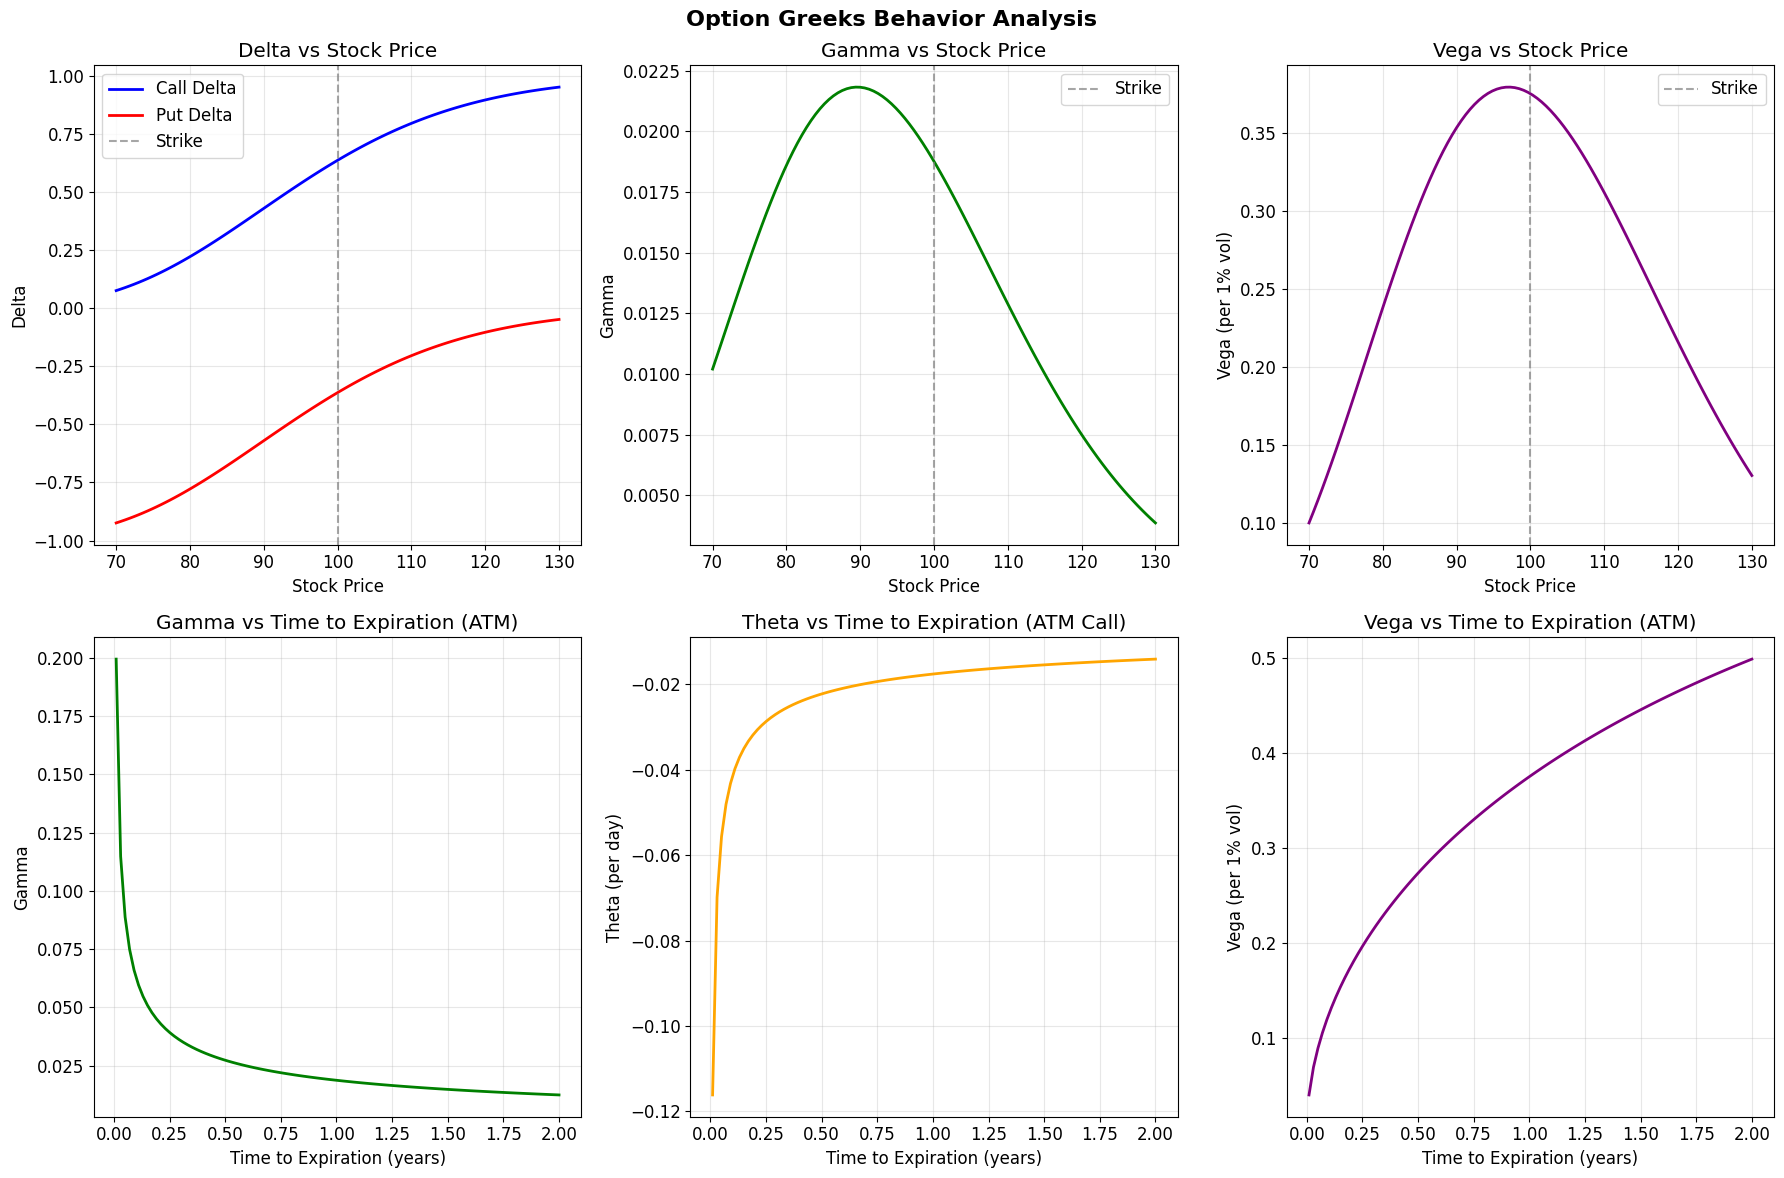


Creating volatility sensitivity visualizations...


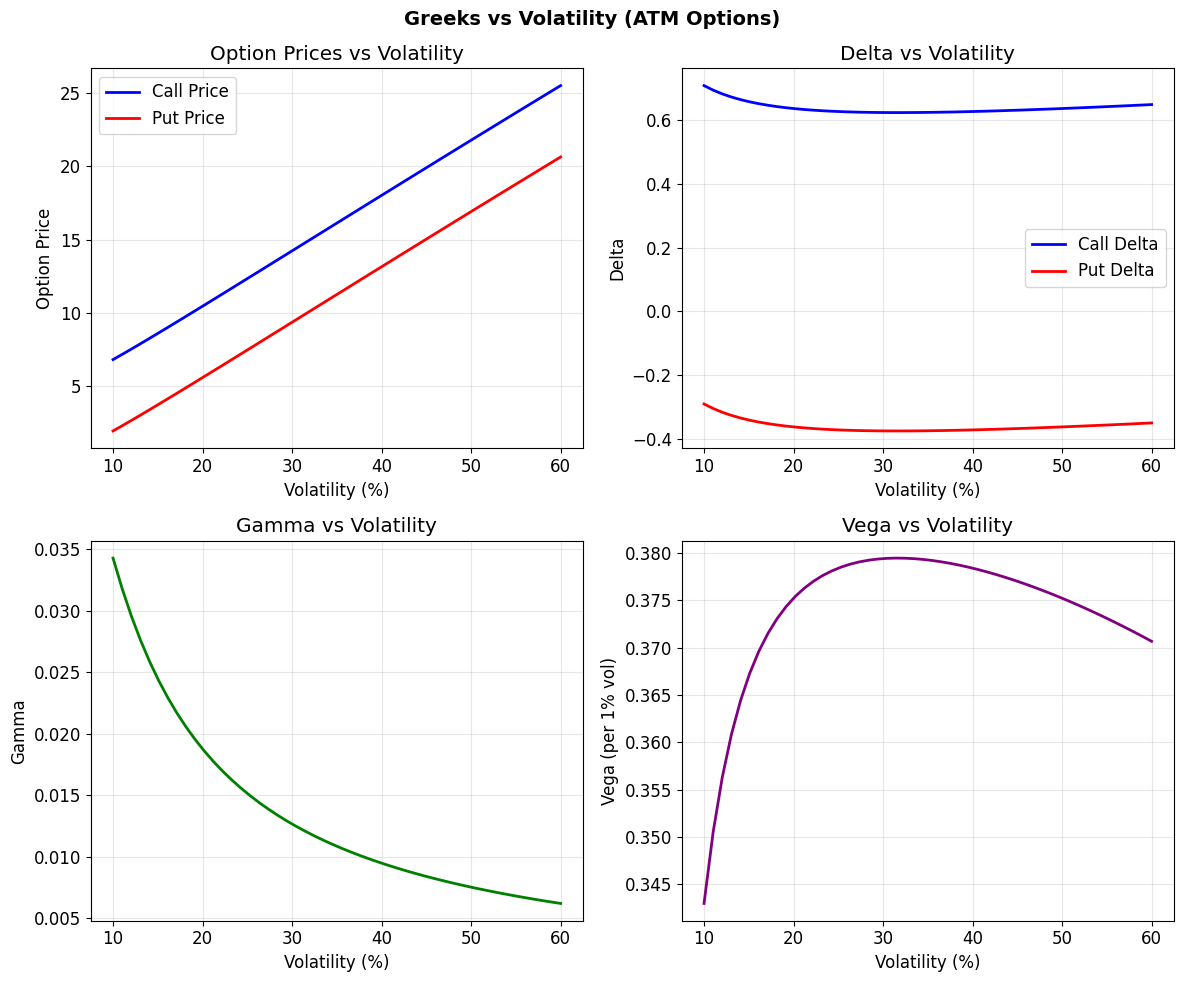

In [24]:
def plot_greeks_behavior():
    """
    Create visualizations showing how Greeks behave under different conditions.
    """
    # Base parameters
    K, T, r, sigma = 100, 1.0, 0.05, 0.2
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Option Greeks Behavior Analysis', fontsize=16, fontweight='bold')
    
    # 1. Greeks vs Stock Price (Moneyness)
    S_range = np.linspace(70, 130, 100)
    deltas_call = []
    deltas_put = []
    gammas = []
    vegas = []
    
    for S in S_range:
        calc = GreeksCalculator(S, K, T, r, sigma)
        deltas_call.append(calc.delta('call'))
        deltas_put.append(calc.delta('put'))
        gammas.append(calc.gamma())
        vegas.append(calc.vega(per_percent=True))
    
    # Plot Delta
    axes[0, 0].plot(S_range, deltas_call, 'b-', label='Call Delta', linewidth=2)
    axes[0, 0].plot(S_range, deltas_put, 'r-', label='Put Delta', linewidth=2)
    axes[0, 0].axvline(K, color='gray', linestyle='--', alpha=0.7, label='Strike')
    axes[0, 0].set_xlabel('Stock Price')
    axes[0, 0].set_ylabel('Delta')
    axes[0, 0].set_title('Delta vs Stock Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot Gamma
    axes[0, 1].plot(S_range, gammas, 'g-', linewidth=2)
    axes[0, 1].axvline(K, color='gray', linestyle='--', alpha=0.7, label='Strike')
    axes[0, 1].set_xlabel('Stock Price')
    axes[0, 1].set_ylabel('Gamma')
    axes[0, 1].set_title('Gamma vs Stock Price')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot Vega
    axes[0, 2].plot(S_range, vegas, 'purple', linewidth=2)
    axes[0, 2].axvline(K, color='gray', linestyle='--', alpha=0.7, label='Strike')
    axes[0, 2].set_xlabel('Stock Price')
    axes[0, 2].set_ylabel('Vega (per 1% vol)')
    axes[0, 2].set_title('Vega vs Stock Price')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 2. Greeks vs Time to Expiration
    S = 100  # At-the-money
    T_range = np.linspace(0.01, 2.0, 100)
    deltas_call_t = []
    gammas_t = []
    thetas_call_t = []
    vegas_t = []
    
    for T_val in T_range:
        calc = GreeksCalculator(S, K, T_val, r, sigma)
        deltas_call_t.append(calc.delta('call'))
        gammas_t.append(calc.gamma())
        thetas_call_t.append(calc.theta('call', per_day=True))
        vegas_t.append(calc.vega(per_percent=True))
    
    # Plot Gamma vs Time
    axes[1, 0].plot(T_range, gammas_t, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Time to Expiration (years)')
    axes[1, 0].set_ylabel('Gamma')
    axes[1, 0].set_title('Gamma vs Time to Expiration (ATM)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot Theta vs Time
    axes[1, 1].plot(T_range, thetas_call_t, 'orange', linewidth=2)
    axes[1, 1].set_xlabel('Time to Expiration (years)')
    axes[1, 1].set_ylabel('Theta (per day)')
    axes[1, 1].set_title('Theta vs Time to Expiration (ATM Call)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot Vega vs Time
    axes[1, 2].plot(T_range, vegas_t, 'purple', linewidth=2)
    axes[1, 2].set_xlabel('Time to Expiration (years)')
    axes[1, 2].set_ylabel('Vega (per 1% vol)')
    axes[1, 2].set_title('Vega vs Time to Expiration (ATM)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_greeks_volatility():
    """
    Show how Greeks change with volatility.
    """
    S, K, T, r = 100, 100, 1.0, 0.05
    vol_range = np.linspace(0.1, 0.6, 50)
    
    call_prices = []
    put_prices = []
    deltas_call = []
    deltas_put = []
    gammas = []
    vegas = []
    
    for vol in vol_range:
        calc = GreeksCalculator(S, K, T, r, vol)
        call_prices.append(calc.price('call'))
        put_prices.append(calc.price('put'))
        deltas_call.append(calc.delta('call'))
        deltas_put.append(calc.delta('put'))
        gammas.append(calc.gamma())
        vegas.append(calc.vega(per_percent=True))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Greeks vs Volatility (ATM Options)', fontsize=14, fontweight='bold')
    
    # Option Prices vs Volatility
    axes[0, 0].plot(vol_range * 100, call_prices, 'b-', label='Call Price', linewidth=2)
    axes[0, 0].plot(vol_range * 100, put_prices, 'r-', label='Put Price', linewidth=2)
    axes[0, 0].set_xlabel('Volatility (%)')
    axes[0, 0].set_ylabel('Option Price')
    axes[0, 0].set_title('Option Prices vs Volatility')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Delta vs Volatility
    axes[0, 1].plot(vol_range * 100, deltas_call, 'b-', label='Call Delta', linewidth=2)
    axes[0, 1].plot(vol_range * 100, deltas_put, 'r-', label='Put Delta', linewidth=2)
    axes[0, 1].set_xlabel('Volatility (%)')
    axes[0, 1].set_ylabel('Delta')
    axes[0, 1].set_title('Delta vs Volatility')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gamma vs Volatility
    axes[1, 0].plot(vol_range * 100, gammas, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Volatility (%)')
    axes[1, 0].set_ylabel('Gamma')
    axes[1, 0].set_title('Gamma vs Volatility')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Vega vs Volatility
    axes[1, 1].plot(vol_range * 100, vegas, 'purple', linewidth=2)
    axes[1, 1].set_xlabel('Volatility (%)')
    axes[1, 1].set_ylabel('Vega (per 1% vol)')
    axes[1, 1].set_title('Vega vs Volatility')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the visualizations
print("Creating Greeks behavior visualizations...")
plot_greeks_behavior()

print("\nCreating volatility sensitivity visualizations...")
plot_greeks_volatility()

## 10. Practical Examples and Applications

Let's explore some practical scenarios where understanding Greeks is crucial for options trading and risk management.

In [25]:
def practical_examples():
    """
    Demonstrate practical applications of Greeks in trading scenarios.
    """
    print("=== PRACTICAL GREEKS APPLICATIONS ===")
    print()
    
    # Scenario 1: Delta Hedging
    print("Scenario 1: Delta Hedging a Call Option Position")
    print("=" * 50)
    
    S, K, T, r, sigma = 100, 105, 0.25, 0.05, 0.25  # 3-month OTM call
    calc = GreeksCalculator(S, K, T, r, sigma)
    
    call_price = calc.price('call')
    call_delta = calc.delta('call')
    
    contracts = 10  # Long 10 call contracts (1000 shares)
    shares_per_contract = 100
    total_shares_equivalent = contracts * shares_per_contract
    
    hedge_shares = int(call_delta * total_shares_equivalent)
    
    print(f"Long {contracts} call contracts at strike ${K}")
    print(f"Current stock price: ${S}")
    print(f"Call option price: ${call_price:.4f}")
    print(f"Call delta: {call_delta:.4f}")
    print(f"")
    print(f"To delta hedge:")
    print(f"Sell {hedge_shares} shares of the underlying stock")
    print(f"Hedge ratio: {call_delta:.4f} (sell {call_delta:.4f} shares per option)")
    print()
    
    # Show what happens if stock moves
    stock_moves = [-2, -1, 1, 2]
    print("Impact of stock price movements on hedged position:")
    print(f"{'Stock Move':<12} {'New Stock':<12} {'New Delta':<12} {'P&L Option':<12} {'P&L Stock':<12} {'Total P&L':<12}")
    print("-" * 80)
    
    for move in stock_moves:
        new_S = S + move
        calc_new = GreeksCalculator(new_S, K, T, r, sigma)
        new_call_price = calc_new.price('call')
        new_delta = calc_new.delta('call')
        
        option_pnl = (new_call_price - call_price) * total_shares_equivalent
        stock_pnl = -move * hedge_shares  # Negative because we're short stock
        total_pnl = option_pnl + stock_pnl
        
        print(f"{move:+8.0f}     {new_S:8.2f}     {new_delta:8.4f}     {option_pnl:+8.2f}     {stock_pnl:+8.2f}     {total_pnl:+8.2f}")
    
    print()
    
    # Scenario 2: Gamma Risk
    print("Scenario 2: Understanding Gamma Risk")
    print("=" * 40)
    
    gamma = calc.gamma()
    print(f"Current Gamma: {gamma:.6f}")
    print(f"")
    print(f"Gamma represents how much Delta will change for a $1 stock move.")
    print(f"For a ${move} stock move, Delta will change by approximately {gamma * move:.6f}")
    print(f"This means you'll need to rebalance your hedge by buying/selling {int(gamma * move * total_shares_equivalent)} shares")
    print()
    
    # Scenario 3: Time Decay (Theta)
    print("Scenario 3: Time Decay Impact")
    print("=" * 30)
    
    theta_daily = calc.theta('call', per_day=True)
    position_theta = theta_daily * total_shares_equivalent
    
    print(f"Daily Theta per contract: ${theta_daily:.4f}")
    print(f"Total position Theta: ${position_theta:.2f} per day")
    print(f"")
    print(f"This position will lose ${abs(position_theta):.2f} in value each day due to time decay,")
    print(f"assuming all other factors remain constant.")
    
    # Show Theta acceleration near expiration
    print(f"\nTheta acceleration as expiration approaches:")
    print(f"{'Days to Exp':<12} {'Theta/Day':<12} {'Total Theta':<12}")
    print("-" * 36)
    
    for days in [90, 60, 30, 14, 7, 1]:
        T_temp = days / 365
        calc_temp = GreeksCalculator(S, K, T_temp, r, sigma)
        theta_temp = calc_temp.theta('call', per_day=True)
        position_theta_temp = theta_temp * total_shares_equivalent
        print(f"{days:8.0f}     {theta_temp:8.4f}     {position_theta_temp:8.2f}")
    
    print()
    
    # Scenario 4: Volatility Sensitivity (Vega)
    print("Scenario 4: Implied Volatility Risk")
    print("=" * 38)
    
    vega_per_percent = calc.vega(per_percent=True)
    position_vega = vega_per_percent * total_shares_equivalent
    
    print(f"Vega per contract (1% vol change): ${vega_per_percent:.4f}")
    print(f"Total position Vega: ${position_vega:.2f}")
    print(f"")
    print(f"If implied volatility increases by 5% (e.g., from 25% to 30%):")
    print(f"Position will gain: ${position_vega * 5:.2f}")
    print(f"")
    print(f"If implied volatility decreases by 3% (e.g., from 25% to 22%):")
    print(f"Position will lose: ${abs(position_vega * -3):.2f}")
    
# Run practical examples
practical_examples()

=== PRACTICAL GREEKS APPLICATIONS ===

Scenario 1: Delta Hedging a Call Option Position
Long 10 call contracts at strike $105
Current stock price: $100
Call option price: $3.4399
Call delta: 0.4099

To delta hedge:
Sell 409 shares of the underlying stock
Hedge ratio: 0.4099 (sell 0.4099 shares per option)

Impact of stock price movements on hedged position:
Stock Move   New Stock    New Delta    P&L Option   P&L Stock    Total P&L   
--------------------------------------------------------------------------------
      -2        98.00       0.3485      -758.06      +818.00       +59.94
      -1        99.00       0.3790      -394.39      +409.00       +14.61
      +1       101.00       0.4411      +425.48      -409.00       +16.48
      +2       102.00       0.4723      +882.19      -818.00       +64.19

Scenario 2: Understanding Gamma Risk
Current Gamma: 0.031098

Gamma represents how much Delta will change for a $1 stock move.
For a $2 stock move, Delta will change by approximately 0

## 12. Summary and Key Takeaways

### Greeks Summary Table

| Greek | Definition | Formula | Key Insights |
|-------|------------|---------|-------------|
| **Delta (Δ)** | Price sensitivity to underlying | $\Delta = \Phi(d_1)$ (call)<br>$\Delta = \Phi(d_1) - 1$ (put) | • Hedge ratio<br>• Probability of finishing ITM<br>• 0 to 1 (calls), -1 to 0 (puts) |
| **Gamma (Γ)** | Delta sensitivity to underlying | $\Gamma = \frac{\phi(d_1)}{S\sigma\sqrt{T}}$ | • Same for calls and puts<br>• Highest for ATM options<br>• Increases as expiration approaches |
| **Theta (Θ)** | Time decay | Complex formula involving $\phi(d_1)$ and $\Phi(d_2)$ | • Negative for long positions<br>• Accelerates near expiration<br>• Highest for ATM options |
| **Vega (ν)** | Volatility sensitivity | $\nu = S\sqrt{T}\phi(d_1)$ | • Same for calls and puts<br>• Always positive<br>• Decreases as expiration approaches |
| **Rho (ρ)** | Interest rate sensitivity | $\rho = KTe^{-rT}\Phi(d_2)$ (call)<br>$\rho = -KTe^{-rT}\Phi(-d_2)$ (put) | • Positive for calls, negative for puts<br>• More important for longer-term options<br>• Generally smallest Greek |

### Key Relationships

1. **Put-Call Parity for Delta**: $\Delta_{call} - \Delta_{put} = 1$
2. **Gamma is the derivative of Delta**: $\Gamma = \frac{\partial \Delta}{\partial S}$
3. **Gamma and Vega are the same for calls and puts**
4. **Greeks interact**: Changes in one factor affect multiple Greeks

### Practical Applications

- **Delta**: Portfolio hedging and risk management
- **Gamma**: Understanding hedge rebalancing frequency
- **Theta**: Time decay planning and income strategies
- **Vega**: Volatility trading and implied volatility risk
- **Rho**: Interest rate risk for long-term options

### Implementation Notes

- **Analytical formulas** are exact and fast but limited to Black-Scholes assumptions
- **Numerical methods** are more flexible but require careful handling of step sizes
- **Validation** through known relationships and edge cases is crucial
- **Greeks are dynamic** and change with market conditions

This notebook provides a complete foundation for understanding and implementing option Greeks in quantitative finance applications.